In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Problem Statement

Bike-sharing companies often struggle to handle sudden rushes in bookings especially during peak hours, weekends, or unexpected weather changes.
These unpredictable spikes lead to shortage of bikes, customer frustration, and inefficient resource use.

## Metric for Training

Cross-Entropy as the training loss because it’s the standard for classification, and it helps the model learn accurate probabilities.

## Metric for Evaluation

Precision because the business cares about not sending drivers to the wrong areas.

In [4]:
df= pd.read_csv(r"/content/ride_demand.csv")
df.head()

,date,location,hour,weekday,is_weekend,occasion,temperature,rain_chance,metro_available,is_holiday,ride_demand
0,2023-09-21,Ameerpet,10.0,3,False,Regular Day,30.2,0,1,False,0.36
1,2019-09-27,Ameerpet,23.0,4,False,Regular Day,32.4,0,1,False,0.23
2,2021-09-30,Madhapur,11.0,3,False,Regular Day,27.3,0,0,False,0.35
3,2024-12-24,Ameerpet,5.0,1,False,Regular Day,35.1,0,1,False,0.38
4,2024-11-03,Secunderabad,23.0,6,True,Regular Day,24.5,0,1,True,0.45


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             18000 non-null  object 
 1   location         17953 non-null  object 
 2   hour             17947 non-null  float64
 3   weekday          18000 non-null  object 
 4   is_weekend       17947 non-null  object 
 5   occasion         17952 non-null  object 
 6   temperature      18000 non-null  float64
 7   rain_chance      18000 non-null  object 
 8   metro_available  17935 non-null  object 
 9   is_holiday       18000 non-null  object 
 10  ride_demand      18000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 1.5+ MB


In [6]:
df.describe()

,hour,temperature,ride_demand
count,17947.000000,18000.000000,18000.000000
mean,14.376943,29.702561,1.952721
std,9.993425,5.252586,9.105656
min,-9.000000,6.600000,-23.000000
25%,9.000000,26.200000,0.340000
50%,14.000000,29.800000,0.520000
75%,19.000000,33.400000,0.820000
max,310.000000,48.600000,298.000000


### Handling Uncommon and Unrealistic Data

In [7]:
df = df[df['hour'] >= 0]
df = df[df['ride_demand'] >= 0]

### Checking Null and Duplicates

df.isnull().sum()

In [8]:
df=df.dropna()

In [9]:
df.duplicated().sum()

np.int64(0)

### Converting Datetime Datatype

In [10]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'] = df['date'].dt.date

### Handling Improper Location Names

In [11]:
df["location"].value_counts(ascending=True).head(50)

,count
location,
Kondapur beside,1
mehdipatnam near,1
Banjara Hills near,1
Nampally near,1
Hyderabad Central near,1
Tolichowki opp,1
charminar near,1
Kondapur opp,1
S.R. Nagar opp,1


In [12]:
df['location'] = df['location'].astype(str).str.strip().str.lower()

In [13]:
df['location'] = df['location'].astype(str).str.replace(r'\b(near|opp|beside)\b', '', regex=True)

In [14]:
df['location'] = df['location'].str.title()

In [15]:
df['location'] = df['location'].astype(str)
df['location'] = df['location'].str.replace(r'[^a-zA-Z ]', '', regex=True)

In [16]:
df['location'] = df['location'].str.strip().str.title()

In [17]:
df["location"].value_counts(ascending=True).head(50)

,count
location,
Lbngar,2
Gchibowli,3
Dilsukhngar,3
Mlkajgiri,3
Hyderbad Central,3
Kcheguda,3
Mehdiptnam,3
Sr Ngar,3
Nmpally,4


In [18]:
df['location'] = df['location'].astype(str).str.strip().str.title()

df['location'] = df['location'].replace({
    'Lbngar': 'Lb Nagar',
    'Lb Ngar': 'Lb Nagar',
    'Lbnagar': 'Lb Nagar',
    'Srnagar': 'S.R. Nagar',
    'Sr Ngar': 'S.R. Nagar',
    'Sr Nagar':'S.R. Nagar',

    'Mlkajgiri': 'Malkajgiri',
    'Mehdiptnam': 'Mehdipatnam',
    'Dilsukhngar': 'Dilsukhnagar',

    'Hyderbad Central': 'Hyderabad Central',
    'Hyderabadcentral': 'Hyderabad Central',

    'Gchibowli': 'Gachibowli',
    'Kachiguda': 'Kacheguda',
    'Kcheguda':'Kacheguda',
    'Kuktpally': 'Kukatpally',
    'Nmpally': 'Nampally',
    'Kondpur': 'Kondapur',
    'Secunderbad': 'Secunderabad',

    'Bnjara Hills': 'Banjara Hills',
    'Banjarahills': 'Banjara Hills',

    'Chrminar': 'Charminar',
    'Mdhapur': 'Madhapur',

    'Hitechcity': 'Hitech City',
    'Jubileehills': 'Jubilee Hills'
})

In [19]:
df["location"].value_counts(ascending=True).head(50)

,count
location,
Kondapur,113
Mehdipatnam,117
Dilsukhnagar,120
Hyderabad Central,131
Lb Nagar,133
Begumpet,134
Nampally,136
S.R. Nagar,140
Tolichowki,140


### Formatting Weekdays Properly

In [20]:
df["weekday"].value_counts()

,count
weekday,
1,2470
6,2467
4,2463
3,2459
0,2457
2,2455
5,2444
Tue,82
Sun,78


In [21]:
weekday_to_num = {
    "Mon": 0, "Tue": 1, "Wed": 2,
    "Thu": 3, "Fri": 4, "Sat": 5, "Sun": 6,
    "0": 0, "1": 1, "2": 2,
    "3": 3, "4": 4, "5": 5, "6": 6
}

In [22]:
df['weekday'] = df['weekday'].astype(str).str.strip().str.title()
df['weekday'] = df['weekday'].map(weekday_to_num)

### Removing Noises from is_weekend Column

In [23]:
df['is_weekend'].value_counts(ascending=True).head(50)

,count
is_weekend,
-0.02,1
0.053,1
-0.105,1
-0.314,1
1.613,1
1.276,1
0.959,1
-0.283,1
1.552,1


In [24]:
df['is_weekend'].value_counts()

,count
is_weekend,
False,10729
True,4271
0.105,8
0.159,7
0.066,7
...,...
1.116,1
-0.543,1
0.253,1


In [25]:
df = df[df['is_weekend'].isin(["True", "False"])]

In [26]:
df["is_weekend"].value_counts()

,count
is_weekend,
False,10729
True,4271


### Creating Copy to perform EDA(Exploratory Data Analysis)

In [27]:
df1=df.copy()

In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15000 non-null  object 
 1   location         15000 non-null  object 
 2   hour             15000 non-null  float64
 3   weekday          15000 non-null  int64  
 4   is_weekend       15000 non-null  object 
 5   occasion         15000 non-null  object 
 6   temperature      15000 non-null  float64
 7   rain_chance      15000 non-null  object 
 8   metro_available  15000 non-null  object 
 9   is_holiday       15000 non-null  object 
 10  ride_demand      15000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.4+ MB


In [29]:
df["ride_demand"].describe()

,ride_demand
count,15000.000000
mean,0.494798
std,0.225571
min,0.000000
25%,0.320000
50%,0.450000
75%,0.670000
max,1.000000


In [30]:
def categorize_demand(x):
    if x <= 0.36:
        return 'Low'
    elif x <= 0.58:
        return 'Medium'
    else:
        return 'High'
df1['ride_demand'] = df['ride_demand'].apply(categorize_demand)
print(df1['ride_demand'].value_counts())

ride_demand
Low       5210
High      5025
Medium    4765
Name: count, dtype: int64


In [31]:
df['is_weekend'] = df['is_weekend'].astype(str)

In [32]:
df['is_holiday'] = df['is_holiday'].astype(str)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15000 non-null  object 
 1   location         15000 non-null  object 
 2   hour             15000 non-null  float64
 3   weekday          15000 non-null  int64  
 4   is_weekend       15000 non-null  object 
 5   occasion         15000 non-null  object 
 6   temperature      15000 non-null  float64
 7   rain_chance      15000 non-null  object 
 8   metro_available  15000 non-null  object 
 9   is_holiday       15000 non-null  object 
 10  ride_demand      15000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.4+ MB


# EDA Non-Visual

In [34]:
# Location with High Rush
rush = df1[df1["ride_demand"] == "High"]["location"].value_counts().nlargest(1)
rush

,count
location,
Kukatpally,741


In [35]:
# Weekday with High Rush
weekday = df1[df1["ride_demand"] == "High"]["weekday"].value_counts().nlargest(1)
weekday

,count
weekday,
5,1991


In [36]:
# Top Hour with High Rush
hour = df1[df1["ride_demand"] == "High"]["hour"].value_counts().nlargest()
hour

,count
hour,
19.0,325
17.0,324
18.0,321
9.0,319
10.0,319


In [37]:
# Top Occassions with High Rush
occa = df1[(df1["ride_demand"] == "High") & (df1["occasion"] != "Regular Day")]
occasion = occa["occasion"].value_counts().nlargest()
occasion

,count
occasion,
Makar Sankranti,80
Holi,77
Ramzan,77
Diwali,75
New Year,73


In [38]:
# metro affects the rush or not
rush_by_metro = df.groupby("metro_available")["ride_demand"].value_counts()
rush_by_metro

metro_available  ride_demand
0                0.37           52
                 1.00           49
                 0.34           47
                 0.33           44
                 0.26           43
                                ..
1                0.05            8
                 0.00            7
                 0.01            6
                 0.03            4
                 0.02            3
Name: count, Length: 198, dtype: int64

# EDA Visual

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15000 non-null  object 
 1   location         15000 non-null  object 
 2   hour             15000 non-null  float64
 3   weekday          15000 non-null  int64  
 4   is_weekend       15000 non-null  object 
 5   occasion         15000 non-null  object 
 6   temperature      15000 non-null  float64
 7   rain_chance      15000 non-null  object 
 8   metro_available  15000 non-null  object 
 9   is_holiday       15000 non-null  object 
 10  ride_demand      15000 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.4+ MB


In [40]:
df2 = df.copy()
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
df2['year'] = df2['date'].dt.year

In [41]:
trend=df2.groupby('year')['ride_demand'].mean().reset_index()
trend

,year,ride_demand
0,2019,0.493127
1,2020,0.499067
2,2021,0.494660
3,2022,0.494056
4,2023,0.493181
5,2024,0.494681


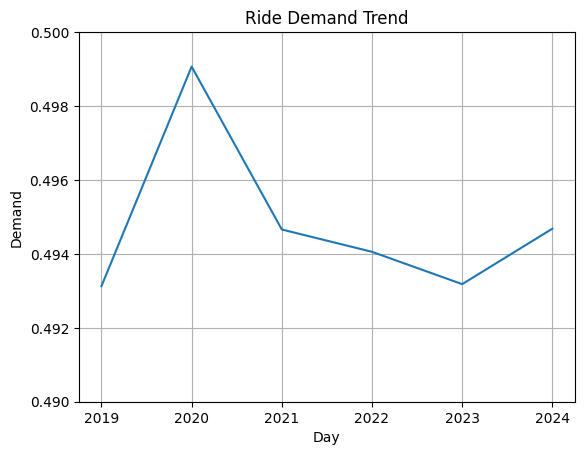

In [42]:
plt.plot(trend["year"], trend["ride_demand"])
plt.title("Ride Demand Trend")
plt.xlabel("Day")
plt.ylabel("Demand")
plt.grid(True)
plt.ylim(0.490, 0.500)
plt.show()

In [43]:
holiday=pd.DataFrame(occasion).reset_index()
holiday

,occasion,count
0,Makar Sankranti,80
1,Holi,77
2,Ramzan,77
3,Diwali,75
4,New Year,73


<Axes: xlabel='occasion', ylabel='count'>

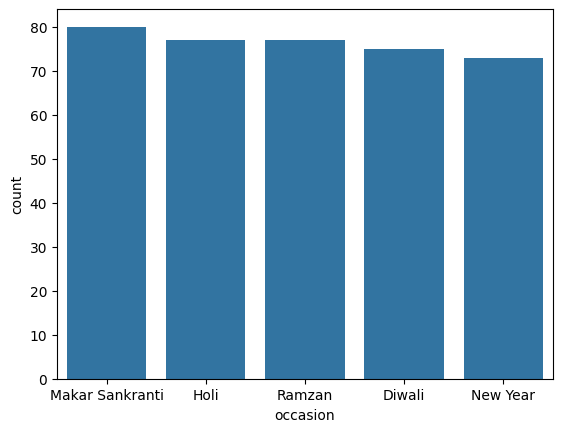

In [44]:
sns.barplot(holiday,x="occasion",y="count")

# Creating Model

In [45]:
df1.head()

,date,location,hour,weekday,is_weekend,occasion,temperature,rain_chance,metro_available,is_holiday,ride_demand
0,2023-09-21,Ameerpet,10.0,3,False,Regular Day,30.2,0,1,False,Low
1,2019-09-27,Ameerpet,23.0,4,False,Regular Day,32.4,0,1,False,Low
2,2021-09-30,Madhapur,11.0,3,False,Regular Day,27.3,0,0,False,Low
3,2024-12-24,Ameerpet,5.0,1,False,Regular Day,35.1,0,1,False,Medium
4,2024-11-03,Secunderabad,23.0,6,True,Regular Day,24.5,0,1,True,Medium


In [46]:
df2 = df1.copy()

In [47]:
y=df2["ride_demand"]

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [49]:
df2['rain_chance'] = df2['rain_chance'].astype(int)
df2['metro_available'] = df2['metro_available'].astype(int)

In [50]:
X=df2.drop(columns=["ride_demand","date"])

In [51]:
X.head()

,location,hour,weekday,is_weekend,occasion,temperature,rain_chance,metro_available,is_holiday
0,Ameerpet,10.0,3,False,Regular Day,30.2,0,1,False
1,Ameerpet,23.0,4,False,Regular Day,32.4,0,1,False
2,Madhapur,11.0,3,False,Regular Day,27.3,0,0,False
3,Ameerpet,5.0,1,False,Regular Day,35.1,0,1,False
4,Secunderabad,23.0,6,True,Regular Day,24.5,0,1,True


In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         15000 non-null  object 
 1   hour             15000 non-null  float64
 2   weekday          15000 non-null  int64  
 3   is_weekend       15000 non-null  object 
 4   occasion         15000 non-null  object 
 5   temperature      15000 non-null  float64
 6   rain_chance      15000 non-null  int64  
 7   metro_available  15000 non-null  int64  
 8   is_holiday       15000 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 1.6+ MB


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

In [54]:
for col in X_train.columns:
    print(col, X_train[col].unique()[:10])

location ['Madhapur' 'Hitech City' 'Banjara Hills' 'Kukatpally' 'Ameerpet'
 'Secunderabad' 'Gachibowli']
hour [11. 23. 17. 10. 21. 12. 20. 16. 22. 19.]
weekday [3 2 4 0 6 1 5]
is_weekend ['False' 'True']
occasion ['Regular Day' 'Eid' 'Christmas' 'Makar Sankranti' 'Holi' 'New Year'
 'Diwali' 'Ramzan']
temperature [27.1 28.3 28.1 29.8 30.5 26.  23.5 36.8 39.1 33. ]
rain_chance [0 1]
metro_available [1 0]
is_holiday ['False' 'True']


In [55]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['location','occasion','is_weekend','is_holiday']),
    ('num', StandardScaler(), ['hour','weekday','temperature','rain_chance',
                               'metro_available'])
])

In [56]:
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

In [57]:
from sklearn.feature_selection import mutual_info_classif

feature_names = transformer.get_feature_names_out()
mi = mutual_info_classif(X_train_trans, y_train)
mi = pd.Series(mi, index=feature_names)
mi.sort_values(ascending=False)

,0
cat__is_holiday_True,0.414107
cat__is_holiday_False,0.398135
cat__is_weekend_False,0.356852
cat__is_weekend_True,0.354966
num__weekday,0.354221
num__rain_chance,0.064968
cat__occasion_Regular Day,0.031344
num__hour,0.030918
cat__occasion_Ramzan,0.011421
cat__occasion_New Year,0.009822


### Creating Base Line Model

In [58]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_trans, y_train)

LogisticRegression(max_iter=1000)

In [59]:
y_pred_encoded = model.predict(X_test_trans)
print(y_pred_encoded[:20])

[2 2 1 1 1 2 1 1 1 1 1 1 2 2 0 0 1 1 0 1]


In [60]:
y_pred = le.inverse_transform(y_pred_encoded)
print(y_pred[:20])

['Medium' 'Medium' 'Low' 'Low' 'Low' 'Medium' 'Low' 'Low' 'Low' 'Low'
 'Low' 'Low' 'Medium' 'Medium' 'High' 'High' 'Low' 'Low' 'High' 'Low']


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_encoded))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1005
           1       0.61      0.99      0.76      1042
           2       0.63      0.27      0.38       953

    accuracy                           0.71      3000
   macro avg       0.72      0.70      0.67      3000
weighted avg       0.72      0.71      0.68      3000



### Performing Hyperparameter Tunning

In [62]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.0 MB/s eta 0:00:00


In [63]:
import optuna

In [64]:
# Importing the required libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [77]:
# Define the objective function for Optuna
def objective(trial):

    classifier_name = trial.suggest_categorical(
        "classifier", ["SVM", "RandomForest", "GradientBoosting", "XGBoost"]
    )

    # ---------------- SVM ----------------
    if classifier_name == "SVM":
        model = SVC(
            C=trial.suggest_float("svm_C", 0.1, 10, log=True),
            kernel=trial.suggest_categorical("svm_kernel", ["linear", "rbf", "poly"]),
            gamma=trial.suggest_categorical("svm_gamma", ["scale", "auto"]),
            probability=True,
            random_state=42
        )

    # ---------------- Random Forest ----------------
    elif classifier_name == "RandomForest":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 300),
            max_depth=trial.suggest_int("rf_max_depth", 3, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 10),
            bootstrap=trial.suggest_categorical("rf_bootstrap", [True, False]),
            random_state=42,
            n_jobs=-1
        )

    # ---------------- Gradient Boosting ----------------
    elif classifier_name == "GradientBoosting":
        model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int("gb_n_estimators", 50, 300),
            learning_rate=trial.suggest_float("gb_learning_rate", 0.01, 0.3, log=True),
            max_depth=trial.suggest_int("gb_max_depth", 3, 10),
            min_samples_split=trial.suggest_int("gb_min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("gb_min_samples_leaf", 1, 10),
            random_state=42
        )

    # ---------------- XGBoost ----------------
    else:
        model = XGBClassifier(
            n_estimators=trial.suggest_int("xgb_n_estimators", 50, 300),
            learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
            max_depth=trial.suggest_int("xgb_max_depth", 3, 10),
            min_child_weight=trial.suggest_int("xgb_min_child_weight", 1, 10),
            gamma=trial.suggest_float("xgb_gamma", 0, 5),
            subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("xgb_colsample", 0.6, 1.0),
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train_trans, y_train, cv=3, scoring='neg_log_loss').mean()
    return -score

In [78]:
# Create a study and optimize it using CmaEsSampler
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

[I 2026-01-12 07:34:42,590] A new study created in memory with name: no-name-22744e21-df88-4fdf-bccf-0f20293c08d5
[I 2026-01-12 07:35:23,313] Trial 0 finished with value: 0.6274120323597034 and parameters: {'classifier': 'SVM', 'svm_C': 0.4930533829654642, 'svm_kernel': 'poly', 'svm_gamma': 'auto'}. Best is trial 0 with value: 0.6274120323597034.
[I 2026-01-12 07:35:26,275] Trial 1 finished with value: 0.5585669052413067 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 243, 'xgb_learning_rate': 0.01778872964411802, 'xgb_max_depth': 8, 'xgb_min_child_weight': 7, 'xgb_gamma': 0.27756679245176497, 'xgb_subsample': 0.741402946103413, 'xgb_colsample': 0.8422837855514482}. Best is trial 1 with value: 0.5585669052413067.
[I 2026-01-12 07:35:50,300] Trial 2 finished with value: 0.6139706342712388 and parameters: {'classifier': 'SVM', 'svm_C': 2.6941119428110145, 'svm_kernel': 'linear', 'svm_gamma': 'scale'}. Best is trial 1 with value: 0.5585669052413067.
[I 2026-01-12 07:35:51,48

In [80]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [79]:
# Create a study and optimize it using CmaEsSampler
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2026-01-12 07:43:11,811] A new study created in memory with name: no-name-622c1665-fd48-4d42-ac8e-b43bef9e3658
[I 2026-01-12 07:43:13,771] Trial 0 finished with value: 0.6115052492058285 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 227, 'rf_max_depth': 5, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 8, 'rf_bootstrap': False}. Best is trial 0 with value: 0.6115052492058285.
[I 2026-01-12 07:43:25,788] Trial 1 finished with value: 0.5530638567405403 and parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 117, 'gb_learning_rate': 0.08041427440565209, 'gb_max_depth': 5, 'gb_min_samples_split': 3, 'gb_min_samples_leaf': 7}. Best is trial 0 with value: 0.6115052492058285.
[I 2026-01-12 07:43:27,197] Trial 2 finished with value: 0.5610416222558279 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 231, 'xgb_learning_rate': 0.01739036361663268, 'xgb_max_depth': 10, 'xgb_min_child_weight': 4, 'xgb_gamma': 4.097147326256559, 'xgb_subsample':

In [81]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

# Final Model Selection

In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.preprocessing import LabelEncoder

y_encoder = LabelEncoder()

y_train_enc = y_encoder.fit_transform(y_train)
y_test_enc = y_encoder.transform(y_test)

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['location','occasion','is_weekend','is_holiday']),
    ('num', StandardScaler(), ['hour','weekday','temperature','rain_chance',
                               'metro_available'])])

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [89]:
pipe.fit(X_train, y_train_enc)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location', 'occasion',
                                                   'is_weekend',
                                                   'is_holiday']),
                                                 ('num', StandardScaler(),
                                                  ['hour', 'weekday',
                                                   'temperature', 'rain_chance',
                                                   'metro_available'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, c...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [90]:
from sklearn.metrics import log_loss, accuracy_score

y_pred_test_enc = pipe.predict(X_test)
y_pred_train_enc = pipe.predict(X_train)

print("Train accuracy:", accuracy_score(y_train_enc, y_pred_train_enc))
print("Test accuracy:", accuracy_score(y_test_enc, y_pred_test_enc))

print("Test log loss:", log_loss(
    y_test_enc, pipe.predict_proba(X_test)
))


Train accuracy: 0.8366666666666667
Test accuracy: 0.7436666666666667
Test log loss: 0.5849842603345774


In [94]:
y_pred_test = y_encoder.inverse_transform(y_pred_test_enc)
y_pred_train = y_encoder.inverse_transform(y_pred_train_enc)

### Dumping the Model

In [95]:
import joblib

joblib.dump(
    {
        "pipeline": pipe,
        "target_encoder": y_encoder
    },
    "model.pkl"
)

['model.pkl']

In [92]:
# Make Predictions
y_pred=pipe.predict(X_test)

In [98]:
bundle = joblib.load("model.pkl")

pipe = bundle["pipeline"]
y_encoder = bundle["target_encoder"]

### Predictions

In [99]:
new_rows = new_data = pd.DataFrame([
    {
        "location": "Ameerpet",
        "hour": 10,
        "weekday": 3,
        "is_weekend": "False",
        "occasion": "Regular Day",
        "temperature": 32,
        "rain_chance": 0.1,
        "metro_available": 1,
        "is_holiday": "False"
    }
])

y_pred_enc = pipe.predict(new_data)
y_pred = y_encoder.inverse_transform(y_pred_enc)

print(y_pred)

['Medium']
